### This notebook contains LSTM approach

In [1]:
import nltk
from nltk.corpus import names
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, GlobalAveragePooling1D, TimeDistributed
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd

# Load NLTK names dataset
nltk.download('names')
male_names = names.words('male.txt')
female_names = names.words('female.txt')

[nltk_data] Downloading package names to /Users/laasya/nltk_data...
[nltk_data]   Package names is already up-to-date!


In [2]:
# Combine and encode names
all_names = male_names + female_names
labels = [0] * len(male_names) + [1] * len(female_names)  # 0 for male, 1 for female

# Convert names to ASCII values
names_ascii = [[ord(char) for char in name.lower()] for name in all_names]

# Pad sequences
names_padded = pad_sequences(names_ascii, padding='post')

# Shuffle data
indices = np.arange(len(labels))
np.random.shuffle(indices)
names_padded = names_padded[indices]
labels = np.array(labels)[indices]


In [3]:
print(f"Number of Male Names:",len(male_names))
print(f"Number of Female Names:", len(female_names))

Number of Male Names: 2943
Number of Female Names: 5001


#### Imbalanced classes - Let's adjust class weights

In [4]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
names_train, names_test, labels_train, labels_test = train_test_split(names_padded, labels, test_size=0.2, random_state=42)

# Split train data into train and val sets
names_train, names_val, labels_train, labels_val = train_test_split(names_train, labels_train, test_size = 0.25, random_state = 42)

In [5]:
# The dataset is heavily imbalanced
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights which will be passed to model during training
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_train),
    y=labels_train)

class_weight_dict = dict(enumerate(class_weights))

In [6]:
# Decode Names
def decode_names(encoded_names):
    decoded_names = []
    for name in encoded_names:
        decoded_name = ''.join(chr(char) for char in name if char != 0)  # Convert ASCII back to characters and ignore padding
        decoded_names.append(decoded_name)
    return decoded_names

decoded_names_test = decode_names(names_test)

label_map = lambda x: "Male" if x == 0 else "Female"

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# LSTM approach

In [8]:
from tensorflow.keras.layers import LSTM, Bidirectional

def build_lstm_model(vocab_size, max_length, lstm_units):
    inputs = Input(shape=(max_length,))
    x = Embedding(vocab_size, 64)(inputs)
    # Setting return_sequences=False to get output from the last timestep
    x = Bidirectional(LSTM(lstm_units, return_sequences=False))(x)
    outputs = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Training

In [9]:
# Assuming models are built and compiled, and data is prepared
from tensorflow.keras.callbacks import EarlyStopping

vocab_size = 128
max_length = 15

# Setup for LSTM model
lstm_units = 128
lstm_model = build_lstm_model(vocab_size, max_length, lstm_units)

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("#"*140)
print("LSTM approach.")
# Train the LSTM model
lstm_history = lstm_model.fit(
    names_train, labels_train,
    # class_weight=class_weight_dict,
    validation_data=(names_val, labels_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

############################################################################################################################################
LSTM approach.
Epoch 1/20
149/149 [==============================] - 3s 13ms/step - loss: 0.5913 - accuracy: 0.6836 - val_loss: 0.5060 - val_accuracy: 0.7489
Epoch 2/20
149/149 [==============================] - 2s 12ms/step - loss: 0.5092 - accuracy: 0.7604 - val_loss: 0.4862 - val_accuracy: 0.7766
Epoch 3/20
149/149 [==============================] - 2s 16ms/step - loss: 0.4791 - accuracy: 0.7822 - val_loss: 0.4617 - val_accuracy: 0.7778
Epoch 4/20
149/149 [==============================] - 3s 21ms/step - loss: 0.4717 - accuracy: 0.7765 - val_loss: 0.4733 - val_accuracy: 0.7772
Epoch 5/20
149/149 [==============================] - 3s 23ms/step - loss: 0.4613 - accuracy: 0.7837 - val_loss: 0.4594 - val_accuracy: 0.7797
Epoch 6/20
149/149 [==============================] - 4s 29ms/step - loss: 0.4382 - accuracy: 0.7996 - val_loss: 0.4448 - val_acc

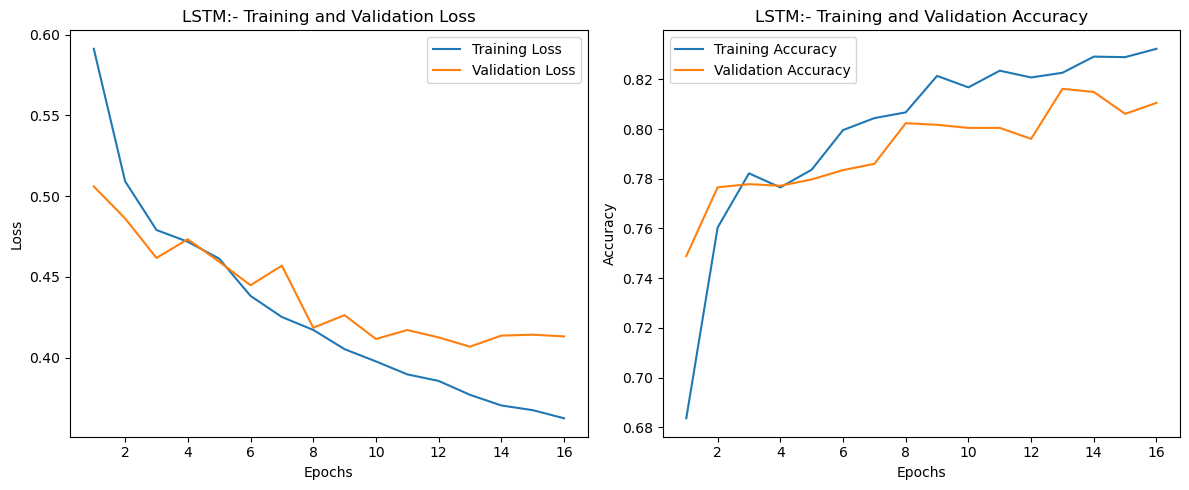

In [10]:
# LSTM
lstm_train_loss = lstm_history.history['loss']
lstm_val_loss = lstm_history.history['val_loss']
lstm_train_accuracy = lstm_history.history['accuracy']  
lstm_val_accuracy = lstm_history.history['val_accuracy']
lstm_epochs = range(1, len(lstm_train_loss) + 1)  # Range of epochs (1 to number of epochs)

plt.figure(figsize=(12, 5))

# Subplot for the LSTM loss
plt.subplot(1, 2, 1) 
plt.plot(lstm_epochs, lstm_train_loss, label='Training Loss')
plt.plot(lstm_epochs, lstm_val_loss, label='Validation Loss')
plt.title('LSTM:- Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot for the LSTM accuracy
plt.subplot(1, 2, 2)  
plt.plot(lstm_epochs, lstm_train_accuracy, label='Training Accuracy')
plt.plot(lstm_epochs, lstm_val_accuracy, label='Validation Accuracy')
plt.title('LSTM:- Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.tight_layout() 
plt.show()

In [11]:
# Make predictions on LSTM
lstm_test_predictions = lstm_model.predict(names_test)
lstm_test_predicted_classes = np.argmax(lstm_test_predictions, axis=1)

lstm_pred_vs_actual = pd.concat([pd.Series(decoded_names_test),pd.Series(lstm_test_predicted_classes).apply(label_map), pd.Series(labels_test).apply(label_map)],
                                     keys = ["name", "predicted", "actual"],axis=1)

print("#"*100)
print("LSTM Pred vs Actual")
print(lstm_pred_vs_actual)
print("#"*100)

50/50 [==============================] - 1s 8ms/step
####################################################################################################
LSTM Pred vs Actual
            name predicted  actual
0            sol      Male    Male
1          nelli    Female  Female
2         zilvia    Female  Female
3         shaine    Female  Female
4         carley    Female  Female
...          ...       ...     ...
1584      loleta    Female  Female
1585     gershon      Male    Male
1586        yale    Female    Male
1587        luna    Female  Female
1588  hyacinthie    Female  Female

[1589 rows x 3 columns]
####################################################################################################


In [12]:
# Wrong LSTM predictions
print(lstm_pred_vs_actual[lstm_pred_vs_actual.predicted != lstm_pred_vs_actual.actual])

          name predicted  actual
11    chrysler      Male  Female
15      sheril      Male  Female
20     thornie    Female    Male
23        beau      Male  Female
25       hetty      Male  Female
...        ...       ...     ...
1570     marty    Female    Male
1573    isaiah    Female    Male
1574      davy    Female    Male
1583  consuelo      Male  Female
1586      yale    Female    Male

[325 rows x 3 columns]


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    return accuracy, precision, recall, f1

def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Use white text if squares are dark; otherwise black
    threshold = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [14]:
# Evaluate LSTM Model
accuracy_lstm, precision_lstm, recall_lstm, f1_lstm = evaluate_model(lstm_model, names_test, labels_test)
print(f"LSTM Model:-\nAccuracy: {accuracy_lstm}\nPrecision: {precision_lstm}\nRecall: {recall_lstm}\nF1 Score: {f1_lstm}")

50/50 [==============================] - 0s 8ms/step
LSTM Model:-
Accuracy: 0.7954688483322845
Precision: 0.817279046673287
Recall: 0.8537344398340249
F1 Score: 0.8351090816844241


######################### LSTM #########################


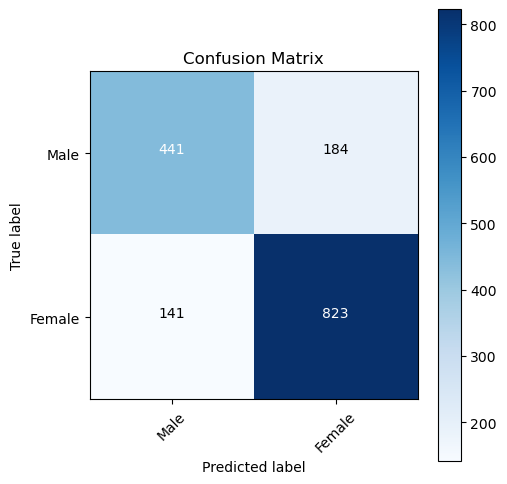

In [15]:
print("#"*25, "LSTM", "#"*25)
cm = confusion_matrix(labels_test, lstm_test_predicted_classes)
plot_confusion_matrix(cm, ["Male", "Female"])